In [2]:
import numpy as np
import pandas as pd
from sklearn.feature_selection import VarianceThreshold
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sktime.performance_metrics.forecasting import MeanAbsoluteScaledError
from prophet import Prophet

# Import Data

In [223]:
mase = MeanAbsoluteScaledError(sp=4)
original = pd.read_csv('new_dataset/owid-covid-data-most-recent.csv')

df = pd.read_csv('multivariate.csv')
df['date'] = pd.to_datetime(df['date'])
df.rename(columns={'date':'ds', 'new_deaths':'y'}, inplace=True)
df = df[df['ds'] < '2024-01-14']
df['ds'] = pd.to_datetime(df['ds'])
df = df.sort_values(by='ds')

# impute missing values
# when total_cases is nan, set is to 0 
df['total_cases'] = df['total_cases'].fillna(0)
df['new_cases'] = df['new_cases'].fillna(0)
df['total_cases_per_million'] = df['total_cases_per_million'].fillna(0)
df['new_cases_per_million'] = df['new_cases_per_million'].fillna(0)
df = df.drop(columns = ['weekly_icu_admissions_per_million'], axis = 1, errors = 'ignore')
vaccine_columns = [col for col in df.columns if 'vaccin' in col]
# for the dates before december 11 2020, for the rows where the vaccine columns are nan, set them to 0
df.loc[df['ds'] < '2020-12-13', vaccine_columns] = df.loc[df['ds'] < '2020-12-13', vaccine_columns].fillna(0)
# remove rows where new_deaths_2_week_mean is nan
df = df.dropna(subset=['new_deaths_2_week_mean'])
# remove rows where new_deaths_4_week_max is nan
df = df.dropna(subset=['new_deaths_4_week_max'])
df = df.dropna(subset=['new_deaths_4_week_lag'])

multivar = df.copy()
multivar = pd.get_dummies(df)

In [234]:
# get totals of na in each column
na_totals = multivar.isna().sum().sort_values(ascending=False)

#get names of columns with number of na = 0
useable_columns = na_totals[na_totals == 0].index.to_list()
na_totals

gdp_stringency_interaction             535
stringency_index                       535
healthcare_strain_index                530
hosp_patients_per_million              374
new_vaccinations                       362
excess_mortality                       354
people_fully_vaccinated_per_hundred    333
icu_utilization_ratio                  332
icu_patients_per_million               332
people_vaccinated_per_hundred          331
total_vaccinations_per_hundred         327
weekly_hosp_admissions_per_million     201
tests_units_people tested                0
cumulative_cases_threshold               0
ds                                       0
season_Autumn                            0
comparison_with_previous                 0
new_deaths_4_week_min                    0
new_deaths_2_week_min                    0
tests_units_tests performed              0
location_Czechia                         0
season_Spring                            0
location_Belgium                         0
location_Ch

In [146]:
# time events

# COVID time window
COVID = pd.DataFrame({
    'holiday': 'COVID',
    'ds': pd.to_datetime(['2020-03-15']),
    'lower_window': -15,
    'upper_window': 15,
})

# Super Bowl time window
superbowl = pd.DataFrame({
    'holiday': 'superbowl',
    'ds': pd.to_datetime(['2020-02-02', '2021-02-07','2023-2-12']),
    'lower_window': -7,
    'upper_window': 1,
})

# vaccine approval time window
vaccine = pd.DataFrame({
    'holiday': 'vaccine',
    'ds': pd.to_datetime(['2020-12-11']),
    'lower_window': -1,
    'upper_window': 31,
})
# Combine all events
events = pd.concat((COVID, superbowl, vaccine))

# Take a look at the events data
events

,holiday,ds,lower_window,upper_window
0,COVID,2020-03-15,-15,15
0,superbowl,2020-02-02,-7,1
1,superbowl,2021-02-07,-7,1
2,superbowl,2023-02-12,-7,1
0,vaccine,2020-12-11,-1,31


In [232]:
top_25_features = ['comparison_with_previous',
 'new_deaths_2_week_min',
 'new_deaths_2_week_mean',
 'new_deaths_2_week_max',
 'new_deaths_2_week_std',
 'new_cases',
 'new_deaths_4_week_std',
 'new_deaths_4_week_lag',
 'new_cases_per_million',
 'new_deaths_4_week_min',
 'new_deaths_4_week_max',
 'new_deaths_1_week_lag',
 'new_deaths_2_week_lag',
 'new_vaccinations',
 'icu_patients_per_million',
 'healthcare_strain_index',
 'hosp_patients_per_million',
 'weekly_icu_admissions_per_million',
 'new_deaths_4_week_mean',
 'excess_mortality',
 'stringency_index',
 'icu_utilization_ratio',
 'weekly_hosp_admissions_per_million',
 'total_vaccinations_per_hundred',
 'cumulative_cases_threshold']

# make a top features list useable columns that are in top 25 features
top_features = [col for col in useable_columns if col in top_25_features]
top_features

['cumulative_cases_threshold',
 'comparison_with_previous',
 'new_deaths_4_week_min',
 'new_deaths_2_week_min',
 'new_deaths_2_week_max',
 'new_deaths_4_week_max',
 'new_deaths_4_week_lag',
 'new_deaths_4_week_std',
 'new_deaths_2_week_std',
 'new_cases',
 'new_cases_per_million',
 'new_deaths_1_week_lag',
 'new_deaths_2_week_lag',
 'new_deaths_2_week_mean',
 'new_deaths_4_week_mean']

# Model Building

In [239]:
train.tail()

,ds,total_cases,new_cases,y,total_cases_per_million,new_cases_per_million,icu_patients_per_million,hosp_patients_per_million,weekly_hosp_admissions_per_million,new_vaccinations,...,location_Belgium,location_Chile,location_Czechia,location_Estonia,location_France,location_Ireland,location_Israel,location_Italy,location_Malaysia,location_United States
1557,2022-11-13,23878193.0,181181.0,484.0,404458.257,3068.915,3.794,113.724,63.553,4136.0,...,0,0,0,0,0,0,0,1,0,0
748,2022-11-13,590592.0,490.0,15.0,445372.169,369.515,3.016,133.478,123.142,42.0,...,0,0,0,1,0,0,0,0,0,0
545,2022-11-13,4546763.0,5214.0,62.0,433273.045,496.856,4.193,47.456,62.798,123.0,...,0,0,1,0,0,0,0,0,0,0
343,2022-11-13,4832838.0,46640.0,194.0,246526.376,2379.138,7.141,NaN,41.268,35.0,...,0,1,0,0,0,0,0,0,0,0
1153,2022-11-13,1676576.0,1805.0,35.0,333772.636,359.339,1.394,67.488,92.885,266.0,...,0,0,0,0,0,1,0,0,0,0


In [237]:
multivar = multivar.sort_index()
multivar = multivar.sort_values(by='ds')
train_size = int(len(multivar) * 0.7)
train, test = multivar[0:train_size], multivar[train_size:]
print(train.shape, test.shape)

model = Prophet(holidays=events,yearly_seasonality=True)

# add built_in country specific holidays 
model.add_country_holidays(country_name='US')

#adding regressors
model.add_regressor('comparison_with_previous', standardize=False)
model.add_regressor('new_deaths_2_week_mean', standardize=False)
model.add_regressor('new_deaths_2_week_max', standardize=False)
model.add_regressor('new_deaths_2_week_std', standardize=False)
model.add_regressor('new_cases', standardize=False)
model.add_regressor('new_deaths_4_week_lag', standardize=False)
model.add_regressor('new_deaths_1_week_lag', standardize=False)
model.add_regressor('new_deaths_2_week_lag', standardize=False)

model = model.fit(train.reset_index(drop=True))

(1399, 55) (600, 55)


02:15:23 - cmdstanpy - INFO - Chain [1] start processing
02:15:23 - cmdstanpy - INFO - Chain [1] done processing
02:15:23 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
02:15:24 - cmdstanpy - INFO - Chain [1] start processing


KeyboardInterrupt: 

In [186]:
future_multivariate = model.make_future_dataframe(periods= len(multivar) - train_size,freq='W')
# Create the time range for the forecast

# Append the regressor values
future_multivariate = pd.merge(future_multivariate, multivar[['ds',
                                                              'comparison_with_previous',
                                                              'new_deaths_2_week_mean',
                                                              'new_deaths_2_week_max',
                                                              'new_deaths_2_week_std',
                                                              'new_cases',
                                                              'new_deaths_4_week_lag',
                                                              'new_deaths_1_week_lag',
                                                              'new_deaths_2_week_lag']], on='ds', how='inner')

# Fill the missing values with the previous value
future_multivariate = future_multivariate.fillna(method='ffill')
future_multivariate.tail(10)

,ds,total_cases,new_cases,total_cases_per_million,new_cases_per_million,icu_patients_per_million,hosp_patients_per_million,weekly_hosp_admissions_per_million,new_vaccinations,total_vaccinations_per_hundred,...,new_deaths_4_week_min,comparison_with_previous,icu_utilization_ratio,healthcare_strain_index,cumulative_cases_threshold,gdp_stringency_interaction,tests_units_people tested,tests_units_tests performed,season_Autumn,season_Spring
116,2022-10-23,95920136.0,283734.0,283544.228,838.730,7.715,62.500,68.604,209544.0,193.13,...,2274.0,681.0,0.278520,25.348375,1892,1.306833e+06,0,0,1,0
117,2022-10-30,96175292.0,255156.0,284298.480,754.253,7.440,62.905,70.191,193902.0,194.51,...,2274.0,126.0,0.268592,25.395307,1893,1.306291e+06,0,0,1,0
118,2022-11-06,96442596.0,267304.0,285088.643,790.163,7.703,64.938,72.018,180259.0,195.66,...,2274.0,-618.0,0.278087,26.224188,1894,1.560066e+06,0,0,1,0
119,2022-11-13,96725493.0,282897.0,285924.899,836.256,7.984,64.938,71.782,158884.0,196.65,...,2290.0,-173.0,0.288231,26.325632,1895,1.559524e+06,0,0,1,0
120,2022-11-20,97000477.0,274984.0,286737.764,812.865,8.392,65.429,73.629,144989.0,197.58,...,2202.0,-88.0,0.302960,26.650181,1896,1.558982e+06,0,0,1,0
121,2022-11-27,97300648.0,300171.0,287625.083,887.319,9.294,78.037,82.890,118916.0,198.12,...,2202.0,417.0,0.335523,31.527437,1897,1.558439e+06,0,0,1,0
122,2022-12-04,97603247.0,302599.0,288519.579,894.496,10.390,89.278,102.199,114738.0,198.80,...,1763.0,-856.0,0.375090,35.981227,1898,1.558439e+06,0,0,0,0
123,2022-12-11,98065470.0,462223.0,289885.931,1366.352,11.425,95.075,105.883,124080.0,199.47,...,1763.0,1272.0,0.412455,38.447653,1899,1.557897e+06,0,0,0,0
124,2022-12-18,98511484.0,446014.0,291204.369,1318.437,12.253,101.505,112.551,113955.0,200.11,...,1763.0,-383.0,0.442347,41.067870,1900,1.557355e+06,0,0,0,0
125,2022-12-25,99019493.0,508009.0,292706.066,1501.697,12.646,100.467,117.113,2556.0,200.52,...,1763.0,381.0,0.456534,40.835018,1901,1.557355e+06,0,0,0,0


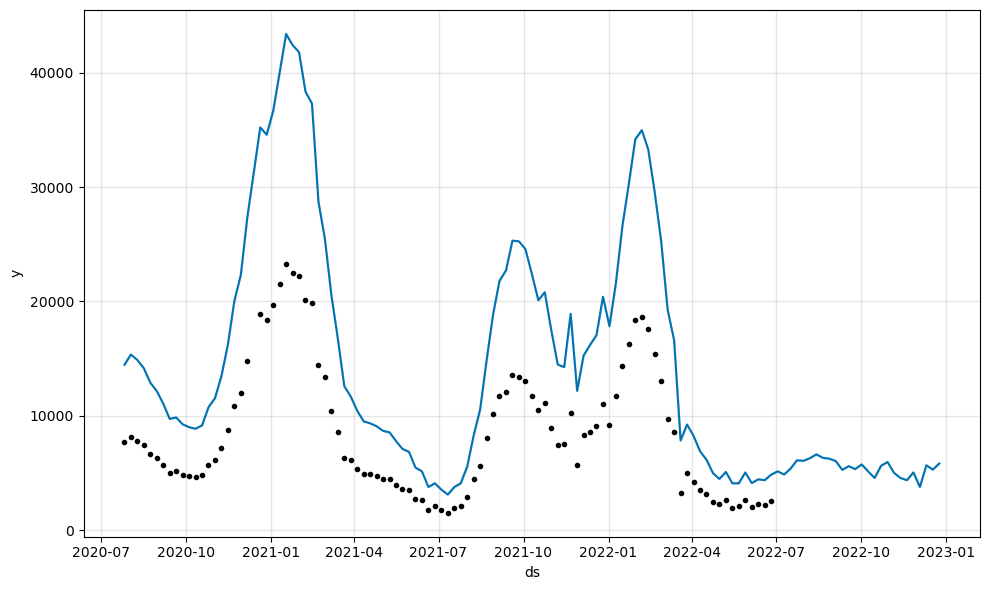

In [187]:
# Make prediction
forecast_multivariate = model.predict(future_multivariate)

# Visualize the forecast
model.plot(forecast_multivariate); # Add semi-colon to remove the duplicated chart

## Belgium